In [1]:
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
football_feed_df = pd.read_pickle('football_feed_df.pkl')
print(football_feed_df.columns)
football_feed_df.head()

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'metadata',
       'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive', 'lang', 'team',
       'user_id', 'retweeted_status_id', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status', 'text', 'hashtags',
       'user_mentions', 'emoji', 'processed_text'],
      dtype='object')


,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,metadata,source,...,user_id,retweeted_status_id,quoted_status_id,quoted_status_id_str,quoted_status,text,hashtags,user_mentions,emoji,processed_text
0,Fri Nov 13 21:27:20 +0000 2020,1327362434361823232,1327362434361823232,- Heisman Trophy winner (1956)\n- No. 1 overal...,False,"[0, 212]","{'hashtags': [{'text': 'Packers', 'indices': [...","{'media': [{'id': 1327340427352174592, 'id_str...","{'result_type': 'popular', 'iso_language_code'...","<a href=""https://studio.twitter.com"" rel=""nofo...",...,35865630,NaN,NaN,NaN,NaN,NaN,"[{'text': 'Packers', 'indices': [182, 190]}]",,[],- Heisman Trophy winner ( 1956 ) - No . 1 over...
1,Fri Nov 13 19:36:20 +0000 2020,1327334499919642625,1327334499919642625,"Paul Hornung, described by Vince Lombardi as ""...",False,"[0, 151]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'result_type': 'popular', 'iso_language_code'...","<a href=""https://mobile.twitter.com"" rel=""nofo...",...,35865630,NaN,NaN,NaN,NaN,NaN,[],,[],"Paul Hornung , described Vince Lombardi `` gre..."
2,Fri Nov 13 18:30:00 +0000 2020,1327317809945325569,1327317809945325569,The entire Pro Football HOF family mourns the ...,False,"[0, 264]","{'hashtags': [{'text': 'HOFForever', 'indices'...","{'media': [{'id': 1327312635180834816, 'id_str...","{'result_type': 'popular', 'iso_language_code'...","<a href=""https://ads.twitter.com"" rel=""nofollo...",...,23632910,NaN,NaN,NaN,NaN,NaN,"[{'text': 'HOFForever', 'indices': [242, 253]}]",Green Bay Packers,[],The entire Pro Football HOF family mourns pass...
3,Sat Nov 14 20:07:06 +0000 2020,1327704633796653064,1327704633796653064,"To all the true heroes, we say thank you. \n\...",False,"[0, 112]","{'hashtags': [{'text': 'SaluteToService', 'ind...","{'media': [{'id': 1326259298645790722, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,724773710549372928,1.327628e+18,NaN,NaN,NaN,NaN,"[{'text': 'SaluteToService', 'indices': [57, 7...",Green Bay Packers,[],"To true hero , say thank . # SaluteToService |"
4,Sat Nov 14 20:06:46 +0000 2020,1327704548304150529,1327704548304150529,Domino’s delivery guy to my house.,False,"[13, 47]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,1314216459892133888,NaN,NaN,NaN,NaN,NaN,[],PFF GB Packers,[],Domino ’ delivery guy house .


In [3]:
#check to see how mnay repeat tweets we scraped. 

print(len(football_feed_df.full_text))
print(len(set(football_feed_df.full_text)))

1200
894


In [4]:
#drop duplicate tweets 
football_feed_df.drop_duplicates(subset=['full_text'], inplace=True)


In [5]:
#check to make sure the number of tweets per team remains similar 
football_feed_df['team'].value_counts()

Bears      164
Raiders    161
Cowboys    154
Packers    149
Chiefs     134
Eagles     132
Name: team, dtype: int64

In [6]:
#shuffle the data 
np.random.seed(1)
df = football_feed_df.reindex(np.random.permutation(football_feed_df.index))

In [7]:
#data is already preprocessed in scrape script

def sentiment_analysis(text):
    text = " ".join(text["processed_text"])
    text = TextBlob(text)

    return text.sentiment.polarity  #returns float in range [-1, 1]

teams_df = football_feed_df[["processed_text", "team"]].groupby("team")
sentiments = teams_df.apply(sentiment_analysis)

In [8]:
sentiments

team
Bears      0.119940
Chiefs     0.072115
Cowboys    0.138313
Eagles     0.191560
Packers    0.179830
Raiders    0.101284
dtype: float64

<AxesSubplot:xlabel='team'>

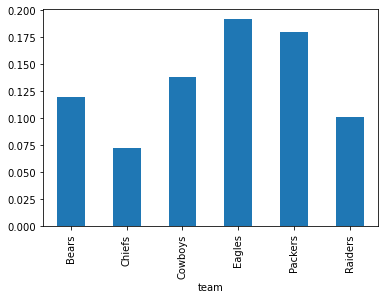

In [9]:
sentiments.plot.bar()

In [10]:
import re
contraction_patterns=[(r'can\'t', 'cannot'),
                    (r'haven\'t', 'have not'),
                    (r'(\w+)\'ll', '\g<1> will'),
                    (r'(\w+)\'re', '\g<1> are'),
                     (r'(\w+)\'ve', '\g<1> have'), 
                     (r'don\'t', 'do not')]

class contraction_replacer(object):
    def __init__(self, contraction_patterns):        
        # store compiled regex object
        self._contraction_regexes = [(re.compile(p), replaced_text) for p, replaced_text in contraction_patterns]
        
    def do_contraction_normalization(self, text):
        for contraction_regex, replaced_text in self._contraction_regexes:
            text = contraction_regex.sub(replaced_text, text)
        return text     
contraction_replacer = contraction_replacer(contraction_patterns)

In [11]:
def clean_tweet(tweet):
    btweet = contraction_replacer.do_contraction_normalization(tweet)
    wnetl = WordNetLemmatizer()
    ctweet = wnetl.lemmatize(btweet)
    word_regex= nltk.RegexpTokenizer(pattern=r'\w+', gaps=False)
    clean_tweet = word_regex.tokenize(ctweet)
    stopwords = nltk.corpus.stopwords.words('english')
    stop_clean_sent = [w for w in clean_tweet if w not in stopwords]
    return stop_clean_sent

In [12]:
clean_football_tweets = football_feed_df["full_text"].apply(clean_tweet)
football_feed_df['tokens'] = football_feed_df["full_text"].apply(clean_tweet)

clean_football_tweets

0       [Heisman, Trophy, winner, 1956, No, 1, overall...
1       [Paul, Hornung, described, Vince, Lombardi, gr...
2       [The, entire, Pro, Football, HOF, family, mour...
3         [To, true, heroes, say, thank, SaluteToService]
4                          [Domino, delivery, guy, house]
                              ...                        
1194    [Judge, Countries, Intelligence, Chiefs, Not, ...
1195                       [Injury, part, game, He, stil]
1196    [Thanks, uploading, cut, I, like, see, 1v1, ru...
1197                              [I, feel, jev, I, love]
1199                                               [0, 1]
Name: full_text, Length: 894, dtype: object

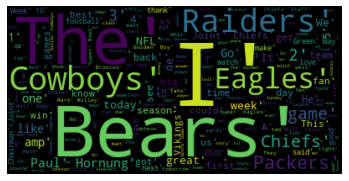

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

unique_string=(" ").join(map(str, clean_football_tweets))
wordcloud = WordCloud().generate(unique_string)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


plt.show()

Packers


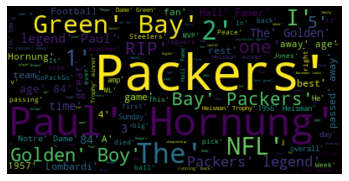

Bears


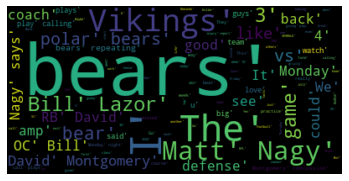

Eagles


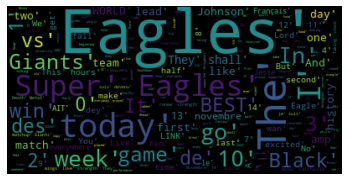

Cowboys


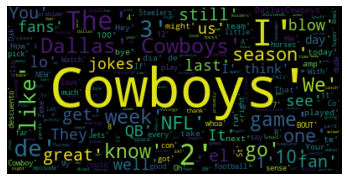

Raiders


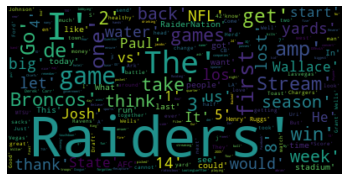

Chiefs


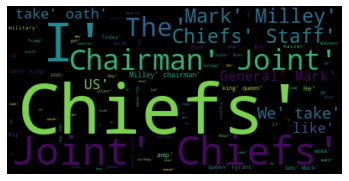

In [14]:
teams = ["Packers","Bears","Eagles", "Cowboys","Raiders", "Chiefs"]

for i in range(len(teams)):
    df = football_feed_df[football_feed_df['team']==teams[i]]
    print(teams[i])
    unique_string=(" ").join(map(str, df.tokens))
    wordcloud = WordCloud().generate(unique_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


    plt.show()

# Some Legit Ass NLP

In [15]:
from nltk.corpus import twitter_samples

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens) 
        
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

In [16]:
clean_positive = pd.Series(positive_tweets).apply(clean_tweet)
clean_negative = pd.Series(negative_tweets).apply(clean_tweet)

clean_positive = get_tweets_for_model(clean_positive)
clean_negative = get_tweets_for_model(clean_negative)


In [17]:
positive_dataset = [(tweet_dict, 1)
                     for tweet_dict in clean_positive]

negative_dataset = [(tweet_dict, 0)
                     for tweet_dict in clean_negative]

dataset = positive_dataset + negative_dataset
random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]
print(train_data)

[({'sambirdracing': True, 'Me': True, 'You': True, 'support': True, 'D': True}, 1), ({'Keep': True, 'smiling': True, 'life': True, 'beautiful': True, 'thing': True, 'much': True, 'smile': True, 'I': True, 'many': True, 'https': True, 'co': True, 'h9gtZ0Y99u': True}, 1), ({'Missing': True, 'Diana': True}, 0), ({'RX931': True, 'Verge': True, 'Owl': True, 'City': True, 'Thanks': True, 'D': True}, 1), ({'wanna': True, 'follow': True, 'personal': True, 'thaiees': True, 'bye': True, 'guysss': True}, 1), ({'ACHI': True, 'Im': True, 'busy': True, 'next': True, 'week': True, 'exams': True, 'Hope': True, 'understand': True, 'I': True, 'cant': True, 'tweet': True, 'youuu': True, 'Bawi': True, 'ako': True, 'queenesther': True, 'esthercarodan': True}, 1), ({'Hallo': True, 'http': True, 'co': True, 'ZuvvBbxiMR': True}, 1), ({'Why': True, 'cannot': True, 'I': True, 'going': True, 'ed': True}, 0), ({'Yahuda': True, 'nosmet': True, 'Thank': True, 'following': True, 'Twitter': True, 'account': True, 'ht

In [18]:

from nltk import classify
from nltk import NaiveBayesClassifier
classifier = nltk.NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))


Accuracy is: 0.763
Most Informative Features
                       D = True                1 : 0      =     83.3 : 1.0
                       p = True                1 : 0      =     60.4 : 1.0
                 arrived = True                1 : 0      =     28.4 : 1.0
                  THANKS = True                0 : 1      =     26.3 : 1.0
                    Love = True                1 : 0      =     23.4 : 1.0
                     sad = True                0 : 1      =     23.3 : 1.0
                    miss = True                0 : 1      =     22.2 : 1.0
                  Thanks = True                1 : 0      =     18.1 : 1.0
                  FOLLOW = True                0 : 1      =     17.6 : 1.0
                    MUCH = True                0 : 1      =     17.6 : 1.0
None


In [20]:
football_clean = get_tweets_for_model(clean_football_tweets)

football_dat = [(tweet_dict)
                     for tweet_dict in football_clean]
football_dat

[{'Heisman': True,
  'Trophy': True,
  'winner': True,
  '1956': True,
  'No': True,
  '1': True,
  'overall': True,
  'draft': True,
  'pick': True,
  '1957': True,
  'NFL': True,
  'MVP': True,
  '1961': True,
  '4': True,
  'time': True,
  'champion': True,
  '1960s': True,
  'All': True,
  'Decade': True,
  'Team': True,
  'Pro': True,
  'Football': True,
  'Hall': True,
  'Famer': True,
  '1986': True,
  'Remembering': True,
  'Packers': True,
  'legend': True,
  'Paul': True,
  'Hornung': True},
 {'Paul': True,
  'Hornung': True,
  'described': True,
  'Vince': True,
  'Lombardi': True,
  'greatest': True,
  'player': True,
  'I': True,
  'ever': True,
  'coached': True,
  'passed': True,
  'away': True,
  'age': True,
  '84': True,
  'RIP': True,
  'Golden': True,
  'Boy': True},
 {'The': True,
  'entire': True,
  'Pro': True,
  'Football': True,
  'HOF': True,
  'family': True,
  'mourns': True,
  'passing': True,
  'Paul': True,
  'Hornung': True,
  'He': True,
  'outstanding'

In [21]:
classifier.classify(football_dat[0])

#Classify each tweet one by one (not a vectorized process)
sentiment = []
for tweet in football_dat:
    s = classifier.classify(tweet)
    sentiment.append(s)

football_feed_df['sentiment'] = sentiment

In [22]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

football_feed_df[['full_text', 'sentiment']]



,full_text,sentiment
0,- Heisman Trophy winner (1956)\n- No. 1 overall draft pick (1957)\n- NFL MVP (1961)\n- 4-time NFL champion \n- 1960s NFL All-Decade Team\n- Pro Football Hall of Famer (1986)\n\nRemembering #Packers legend Paul Hornung​.,1
1,"Paul Hornung, described by Vince Lombardi as ""the greatest player I ever coached,"" has passed away at age 84.\n\nRIP, Golden Boy.",0
2,"The entire Pro Football HOF family mourns the passing of Paul Hornung. He was an outstanding player and an incredible man. Known as ""The Golden Boy,"" Paul was above all a leader to whom the Packers looked for the big plays in the big games.\n\n#HOFForever |",1
3,"To all the true heroes, we say thank you. \n\n#SaluteToService |",1
4,Domino’s delivery guy to my house.,0
...,...,...
1194,"Judge Countries by their Intelligence Chiefs, Not Diplomats | The National Interest",1
1195,Injury’s are a part of the game. He stil…,1
1196,Thanks for uploading this cut-up. I'd like to see some more 1v1 runblocking…,1
1197,I feel it jev I love you,0
